In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [16]:
# op_n_64
rows_interval = 8
rows_min = rows_interval
rows_max = 256
rows = int(rows_max/rows_interval) - int(rows_min/rows_interval) + 1

columns_interval = rows_interval
columns_min = rows_min
columns_max = rows_max
columns = int(columns_max/columns_interval) - int(columns_min/columns_interval) + 1

batch_count = 1000

operation = "op_n"
precision = 64

median_array_op_n_64 = np.zeros((rows, columns))

In [17]:
# load data
for i, n in enumerate(range(rows_min, rows_max + 1, rows_interval)):
    for j, m in enumerate(range(columns_min, columns_max + 1, columns_interval)):
        try:
            directoryname = f"../blas_results/{operation}_{precision}/{n}_{m}_{batch_count}"
            filename = "results.csv"
            df = pd.read_csv(f"{directoryname}/{filename}", usecols=["BeginNs", "EndNs"])
            subtracted_df = df["EndNs"] - df["BeginNs"]
            subtracted_array = subtracted_df.to_numpy()
            median_array_op_n_64[i, j] = np.median(subtracted_array) / 1000
        except:
            print(n,m)

In [18]:
print(np.max(median_array_op_n_64))
# accounting for spike at 128x128
# print(op_n_median_array.shape)
# argmax = (np.argmax(op_n_median_array))
# op_n_median_array[int(argmax/columns), (argmax % columns)] = 0
# argmax = (np.argmax(op_n_median_array))
# median_array[int(argmax/columns), (argmax % columns)] = 0
print(np.nanmax(median_array_op_n_64))

522.244
522.244


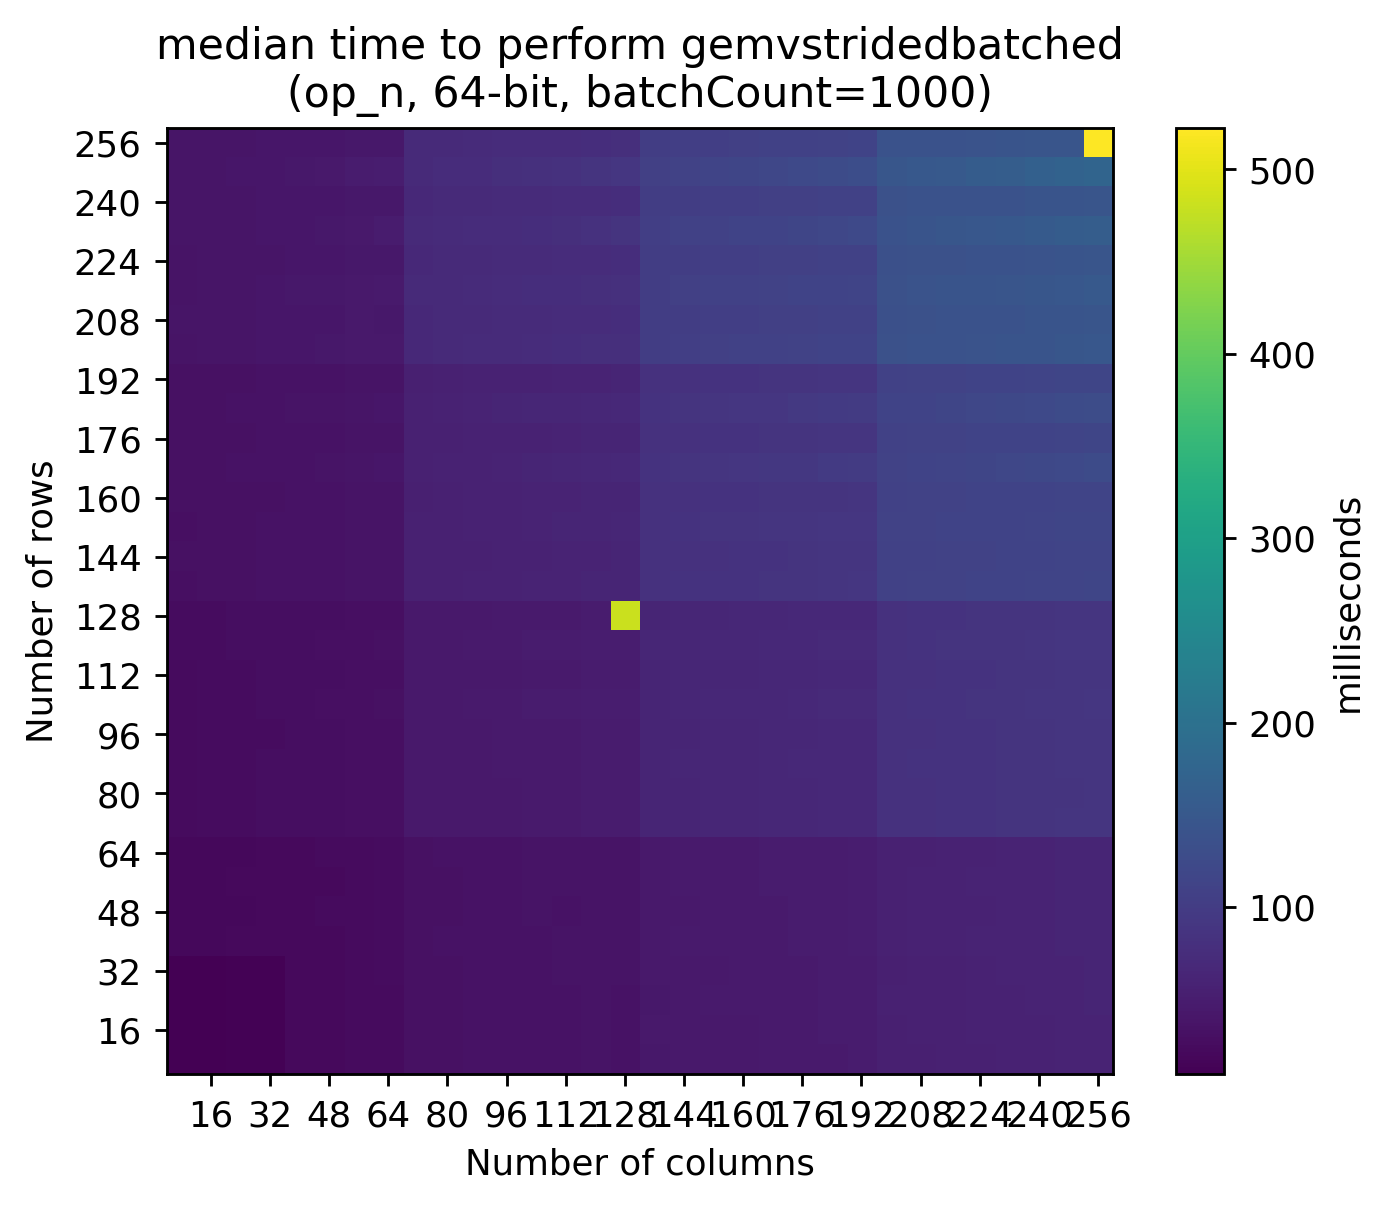

In [19]:
fig, ax = plt.subplots(dpi=256)

c = ax.imshow(median_array_op_n_64, 
              origin="lower", 
              interpolation='none',
              extent=[columns_min-columns_interval/2,
                      columns_max+columns_interval/2,
                      rows_min-rows_interval/2,
                      rows_max+rows_interval/2,
                      ],
)
plt.title(
    f"median time to perform gemvstridedbatched\n({operation}, {precision}-bit, batchCount={batch_count})"
)
plt.xlabel("Number of columns")
plt.ylabel("Number of rows")
cbar = plt.colorbar(c)

cbar.ax.set_ylabel("milliseconds")
plt.xticks(range(2*columns_min, columns_max + 1, 2*columns_interval))
plt.yticks(range(2*rows_min, rows_max + 1, 2*rows_interval))

plt.show()

In [20]:
# OP_T
operation = "op_t"
median_array_op_t_64 = np.zeros((rows, columns))
# load data
for i, n in enumerate(range(rows_min, rows_max + 1, rows_interval)):
    for j, m in enumerate(range(columns_min, columns_max + 1, columns_interval)):
        try:
            directoryname = f"../blas_results/{operation}_{precision}/{n}_{m}_{batch_count}"
            filename = "results.csv"
            df = pd.read_csv(f"{directoryname}/{filename}", usecols=["BeginNs", "EndNs"])
            subtracted_df = df["EndNs"] - df["BeginNs"]
            subtracted_array = subtracted_df.to_numpy()
            median_array_op_t_64[i,j] = np.median(subtracted_array) / 1000
        except:
            print(n,m)

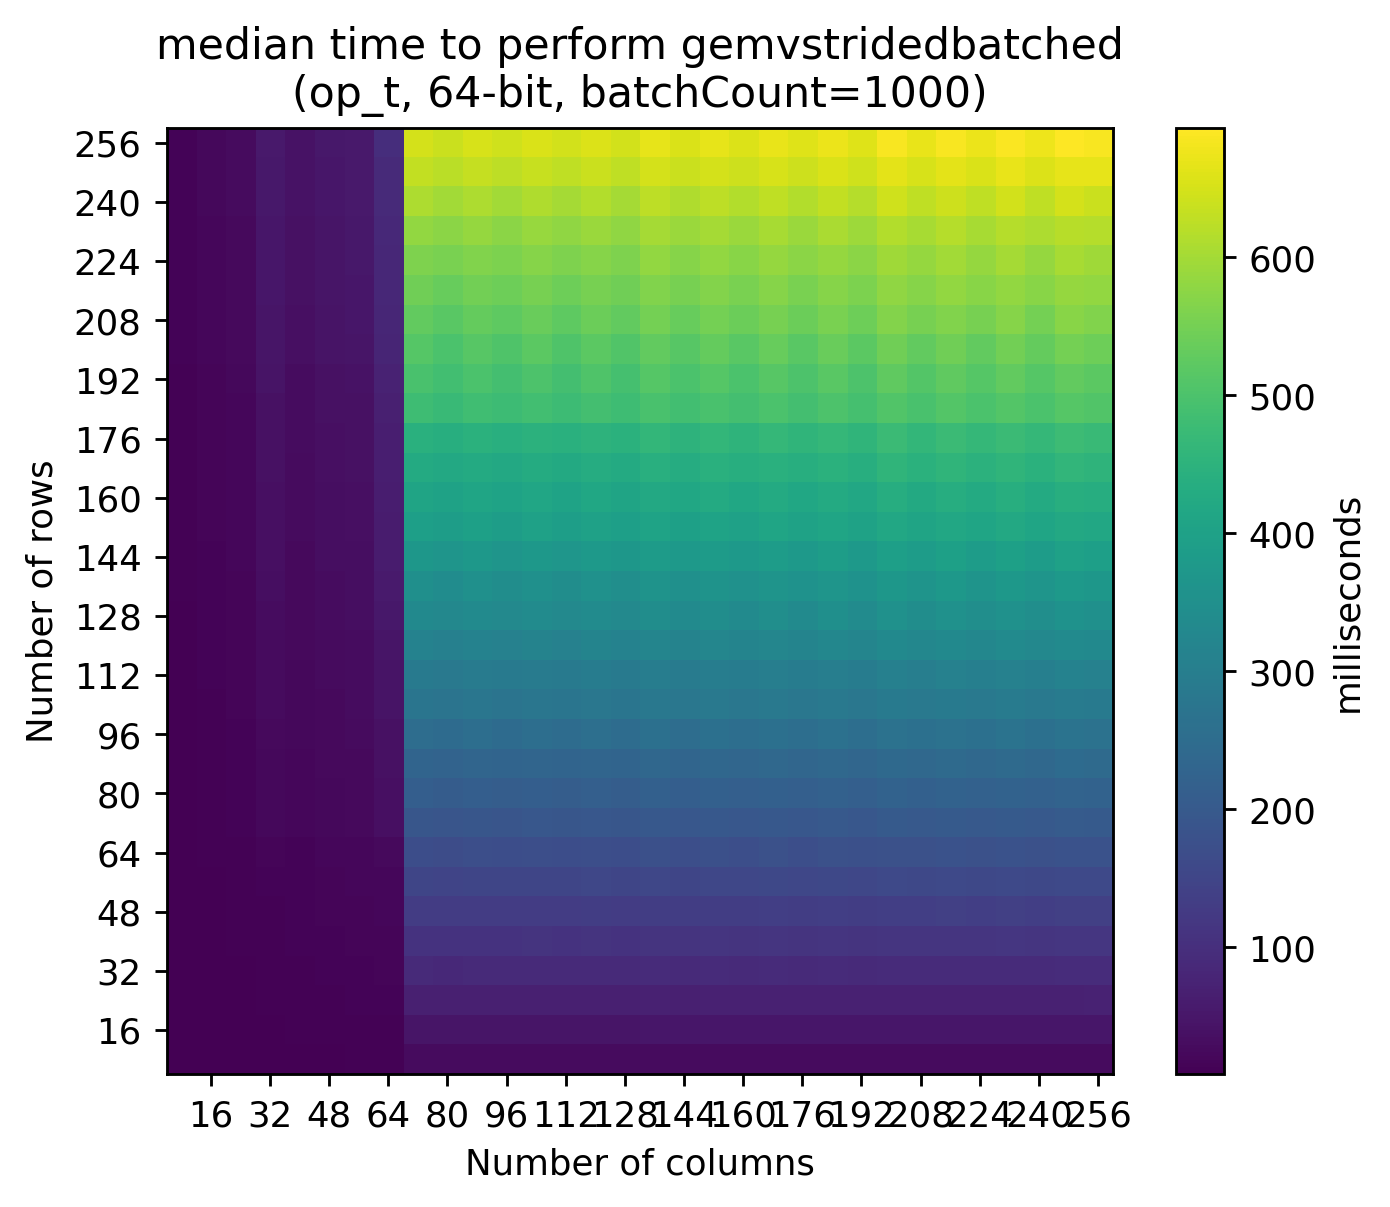

In [21]:
fig, ax = plt.subplots(dpi=256)

c = ax.imshow(median_array_op_t_64, 
              origin="lower", 
              interpolation='none',
              extent=[columns_min-columns_interval/2,
                      columns_max+columns_interval/2,
                      rows_min-rows_interval/2,
                      rows_max+rows_interval/2,
                      ],
)
plt.title(
    f"median time to perform gemvstridedbatched\n({operation}, {precision}-bit, batchCount={batch_count})"
)
plt.xlabel("Number of columns")
plt.ylabel("Number of rows")
cbar = plt.colorbar(c)

cbar.ax.set_ylabel("milliseconds")
plt.xticks(range(2*columns_min, columns_max + 1, 2*columns_interval))
plt.yticks(range(2*rows_min, rows_max + 1, 2*rows_interval))

plt.show()

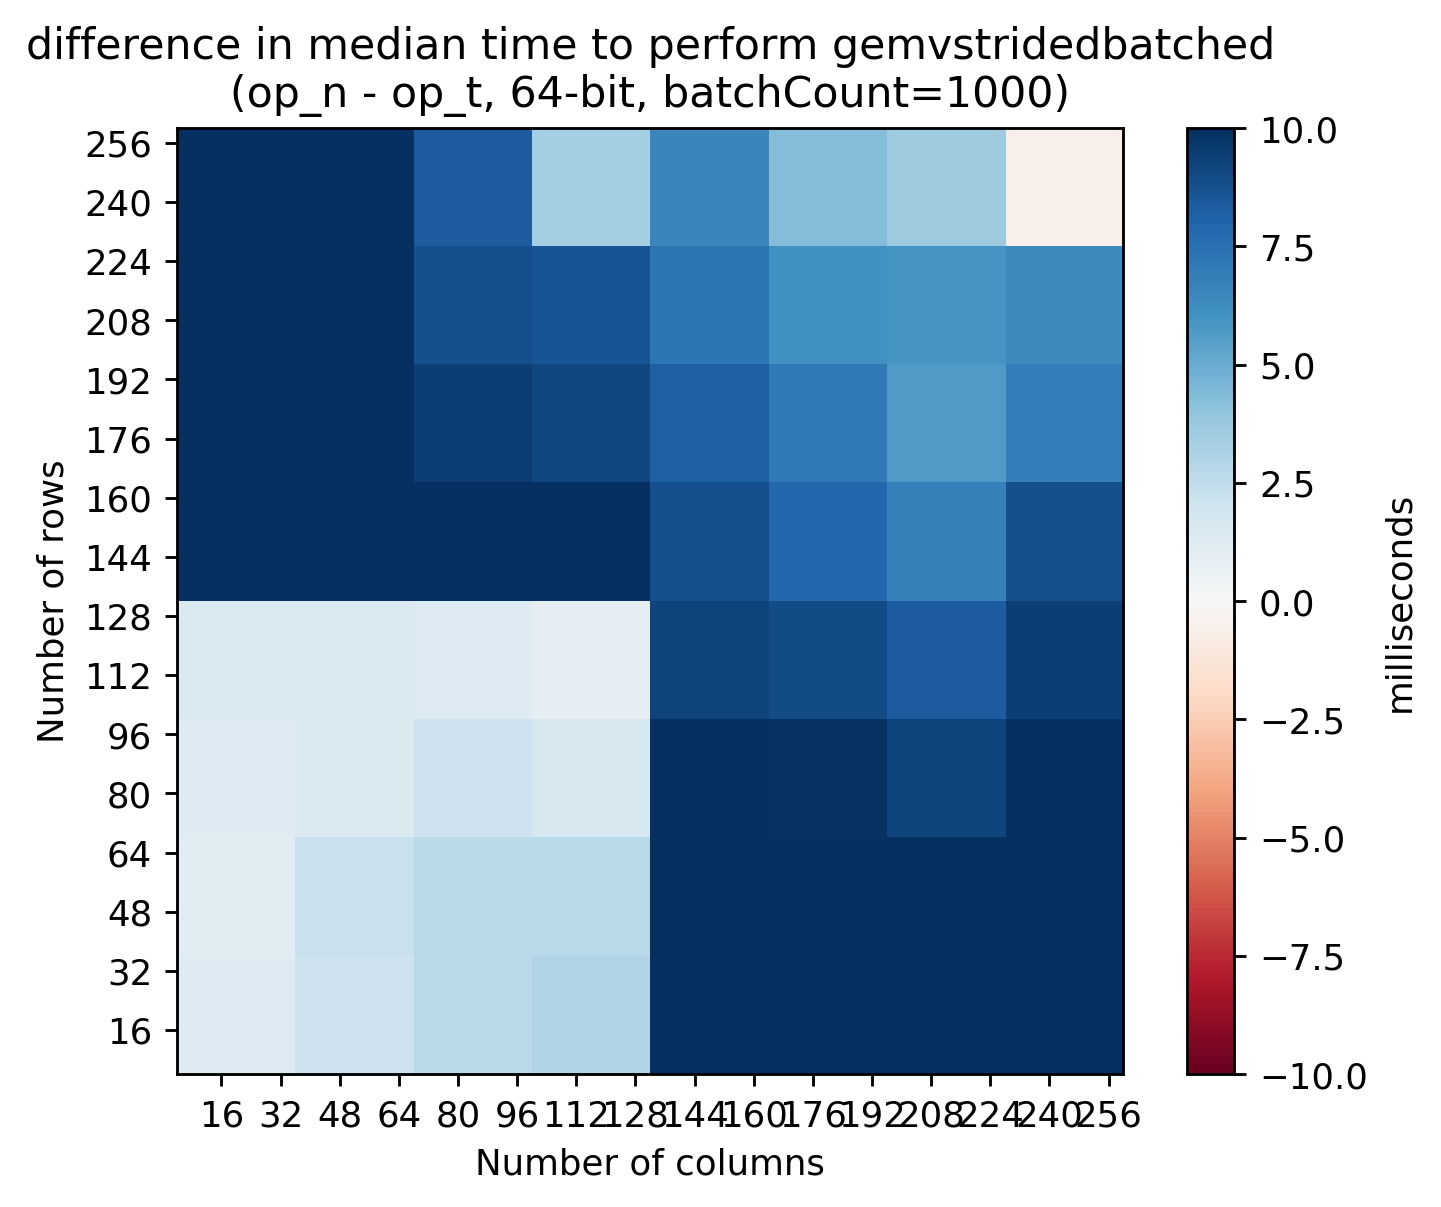

In [22]:
# op_n - op_t
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import BoundaryNorm
fig, ax = plt.subplots(dpi=256)

difference_array = median_array_op_n_64 - median_array_op_t_64

c = ax.imshow(difference_array[0:8,0:8], 
              origin="lower", 
              interpolation='none',
              extent=[
                  columns_min-columns_interval/2,
                  columns_max+columns_interval/2,
                  rows_min-rows_interval/2,
                  rows_max+rows_interval/2,
              ],
              cmap="RdBu",
              vmin=-10,
              vmax=10,
)
plt.title(
    f"difference in median time to perform gemvstridedbatched\n(op_n - op_t, {precision}-bit, batchCount={batch_count})"
)
plt.xlabel("Number of columns")
plt.ylabel("Number of rows")

#colormap stuff
cbar = plt.colorbar(c)

cbar.ax.set_ylabel("milliseconds")
plt.xticks(range(2*columns_min, columns_max + 1, 2*columns_interval))
plt.yticks(range(2*rows_min, rows_max + 1, 2*rows_interval))

plt.show()

In [23]:
# op_n_32
rows_interval = 8
rows_min = rows_interval
rows_max = 256
rows = int(rows_max/rows_interval) - int(rows_min/rows_interval) + 1

columns_interval = rows_interval
columns_min = rows_min
columns_max = rows_max
columns = int(columns_max/columns_interval) - int(columns_min/columns_interval) + 1

batch_count = 1000

operation = "op_n"
precision = 32

median_array_op_n_32 = np.zeros((rows, columns))

In [24]:
# load data
for i, n in enumerate(range(rows_min, rows_max + 1, rows_interval)):
    for j, m in enumerate(range(columns_min, columns_max + 1, columns_interval)):
        try:
            directoryname = f"../blas_results/{operation}_{precision}/{n}_{m}_{batch_count}"
            filename = "results.csv"
            df = pd.read_csv(f"{directoryname}/{filename}", usecols=["BeginNs", "EndNs"])
            subtracted_df = df["EndNs"] - df["BeginNs"]
            subtracted_array = subtracted_df.to_numpy()
            median_array_op_n_32[i, j] = np.median(subtracted_array) / 1000
        except:
            print(n,m)

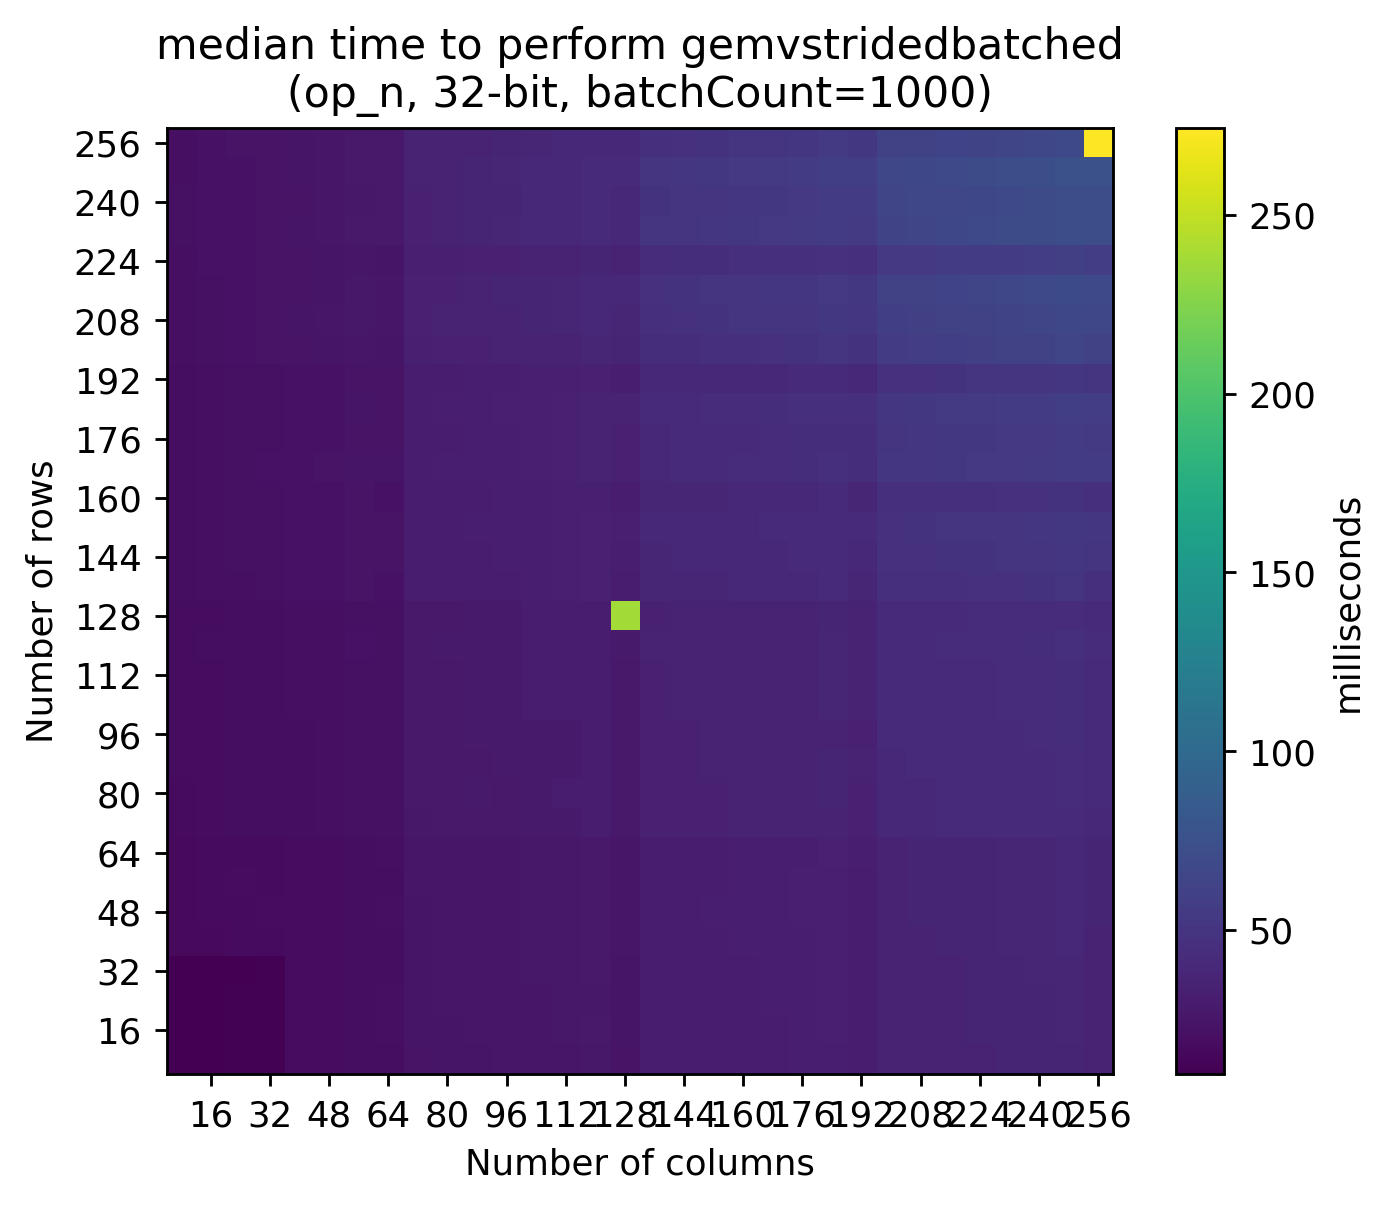

In [25]:
fig, ax = plt.subplots(dpi=256)

c = ax.imshow(median_array_op_n_32, 
              origin="lower", 
              interpolation='none',
              extent=[columns_min-columns_interval/2,
                      columns_max+columns_interval/2,
                      rows_min-rows_interval/2,
                      rows_max+rows_interval/2,
                      ],
)
plt.title(
    f"median time to perform gemvstridedbatched\n({operation}, {precision}-bit, batchCount={batch_count})"
)
plt.xlabel("Number of columns")
plt.ylabel("Number of rows")
cbar = plt.colorbar(c)

cbar.ax.set_ylabel("milliseconds")
plt.xticks(range(2*columns_min, columns_max + 1, 2*columns_interval))
plt.yticks(range(2*rows_min, rows_max + 1, 2*rows_interval))

plt.show()

In [26]:
# op_t_32
operation = "op_t"
median_array_op_t_32 = np.zeros((rows, columns))
# load data
for i, n in enumerate(range(rows_min, rows_max + 1, rows_interval)):
    for j, m in enumerate(range(columns_min, columns_max + 1, columns_interval)):
        try:
            directoryname = f"../blas_results/{operation}_{precision}/{n}_{m}_{batch_count}"
            filename = "results.csv"
            df = pd.read_csv(f"{directoryname}/{filename}", usecols=["BeginNs", "EndNs"])
            subtracted_df = df["EndNs"] - df["BeginNs"]
            subtracted_array = subtracted_df.to_numpy()
            median_array_op_t_32[i,j] = np.median(subtracted_array) / 1000
        except:
            print(n,m)

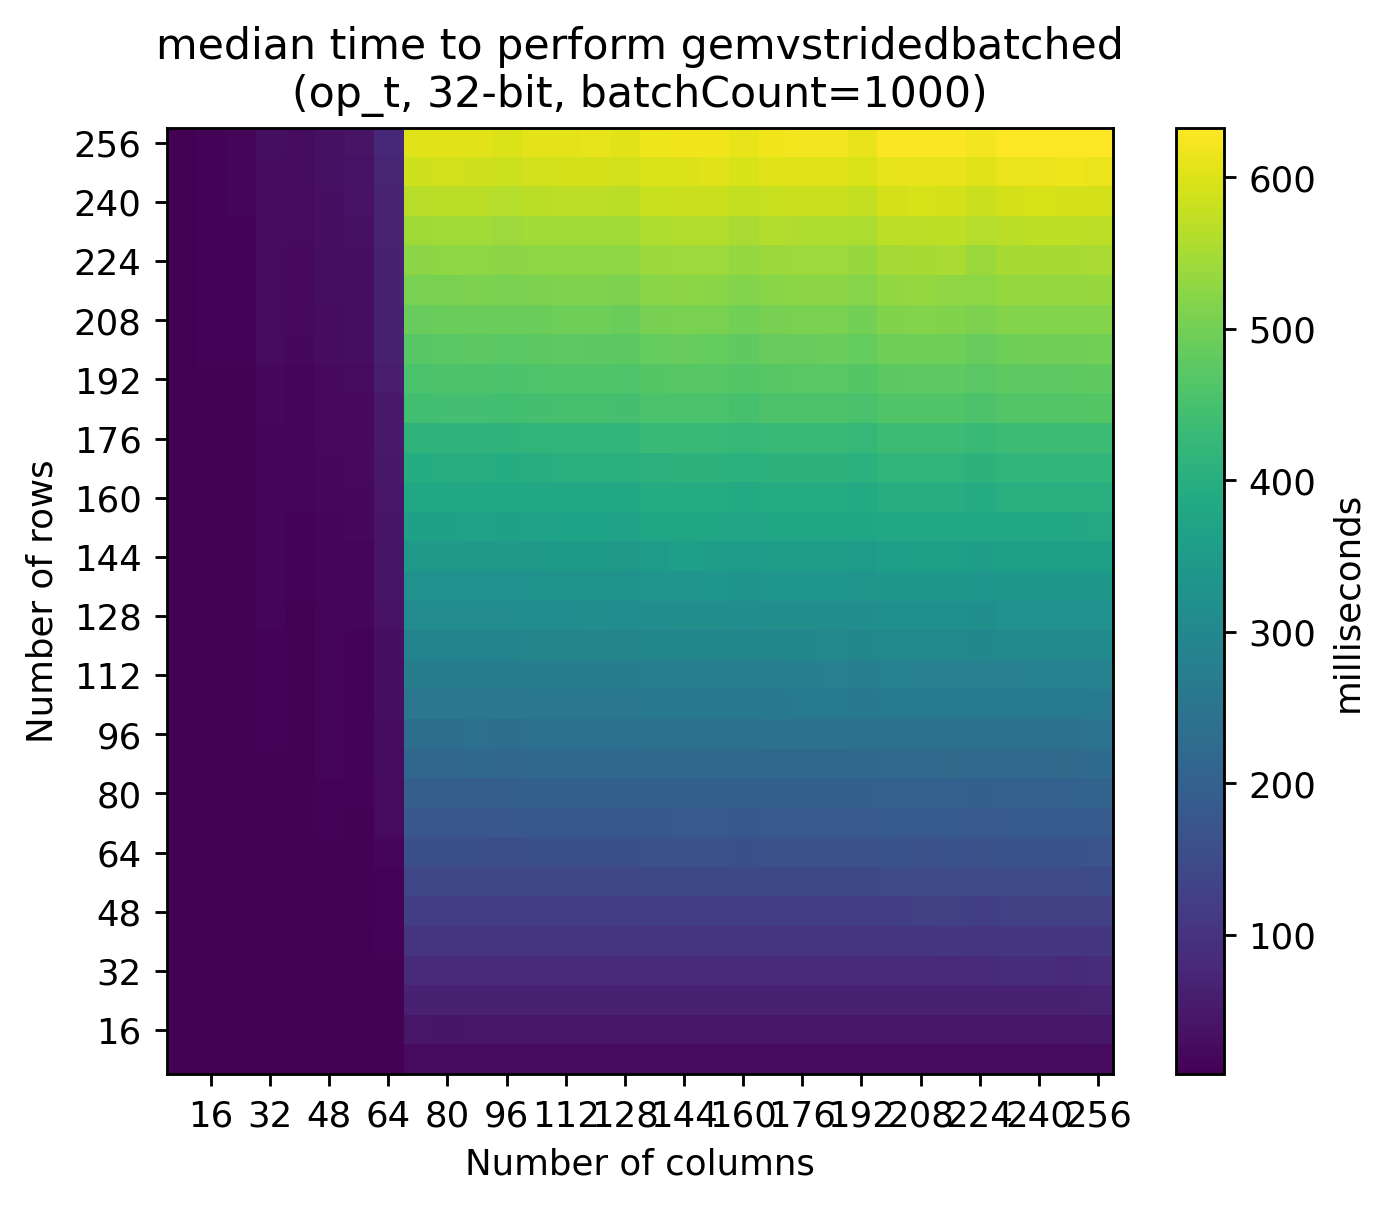

In [27]:
fig, ax = plt.subplots(dpi=256)

c = ax.imshow(median_array_op_t_32, 
              origin="lower", 
              interpolation='none',
              extent=[columns_min-columns_interval/2,
                      columns_max+columns_interval/2,
                      rows_min-rows_interval/2,
                      rows_max+rows_interval/2,
                      ],
)
plt.title(
    f"median time to perform gemvstridedbatched\n({operation}, {precision}-bit, batchCount={batch_count})"
)
plt.xlabel("Number of columns")
plt.ylabel("Number of rows")
cbar = plt.colorbar(c)

cbar.ax.set_ylabel("milliseconds")
plt.xticks(range(2*columns_min, columns_max + 1, 2*columns_interval))
plt.yticks(range(2*rows_min, rows_max + 1, 2*rows_interval))

plt.show()

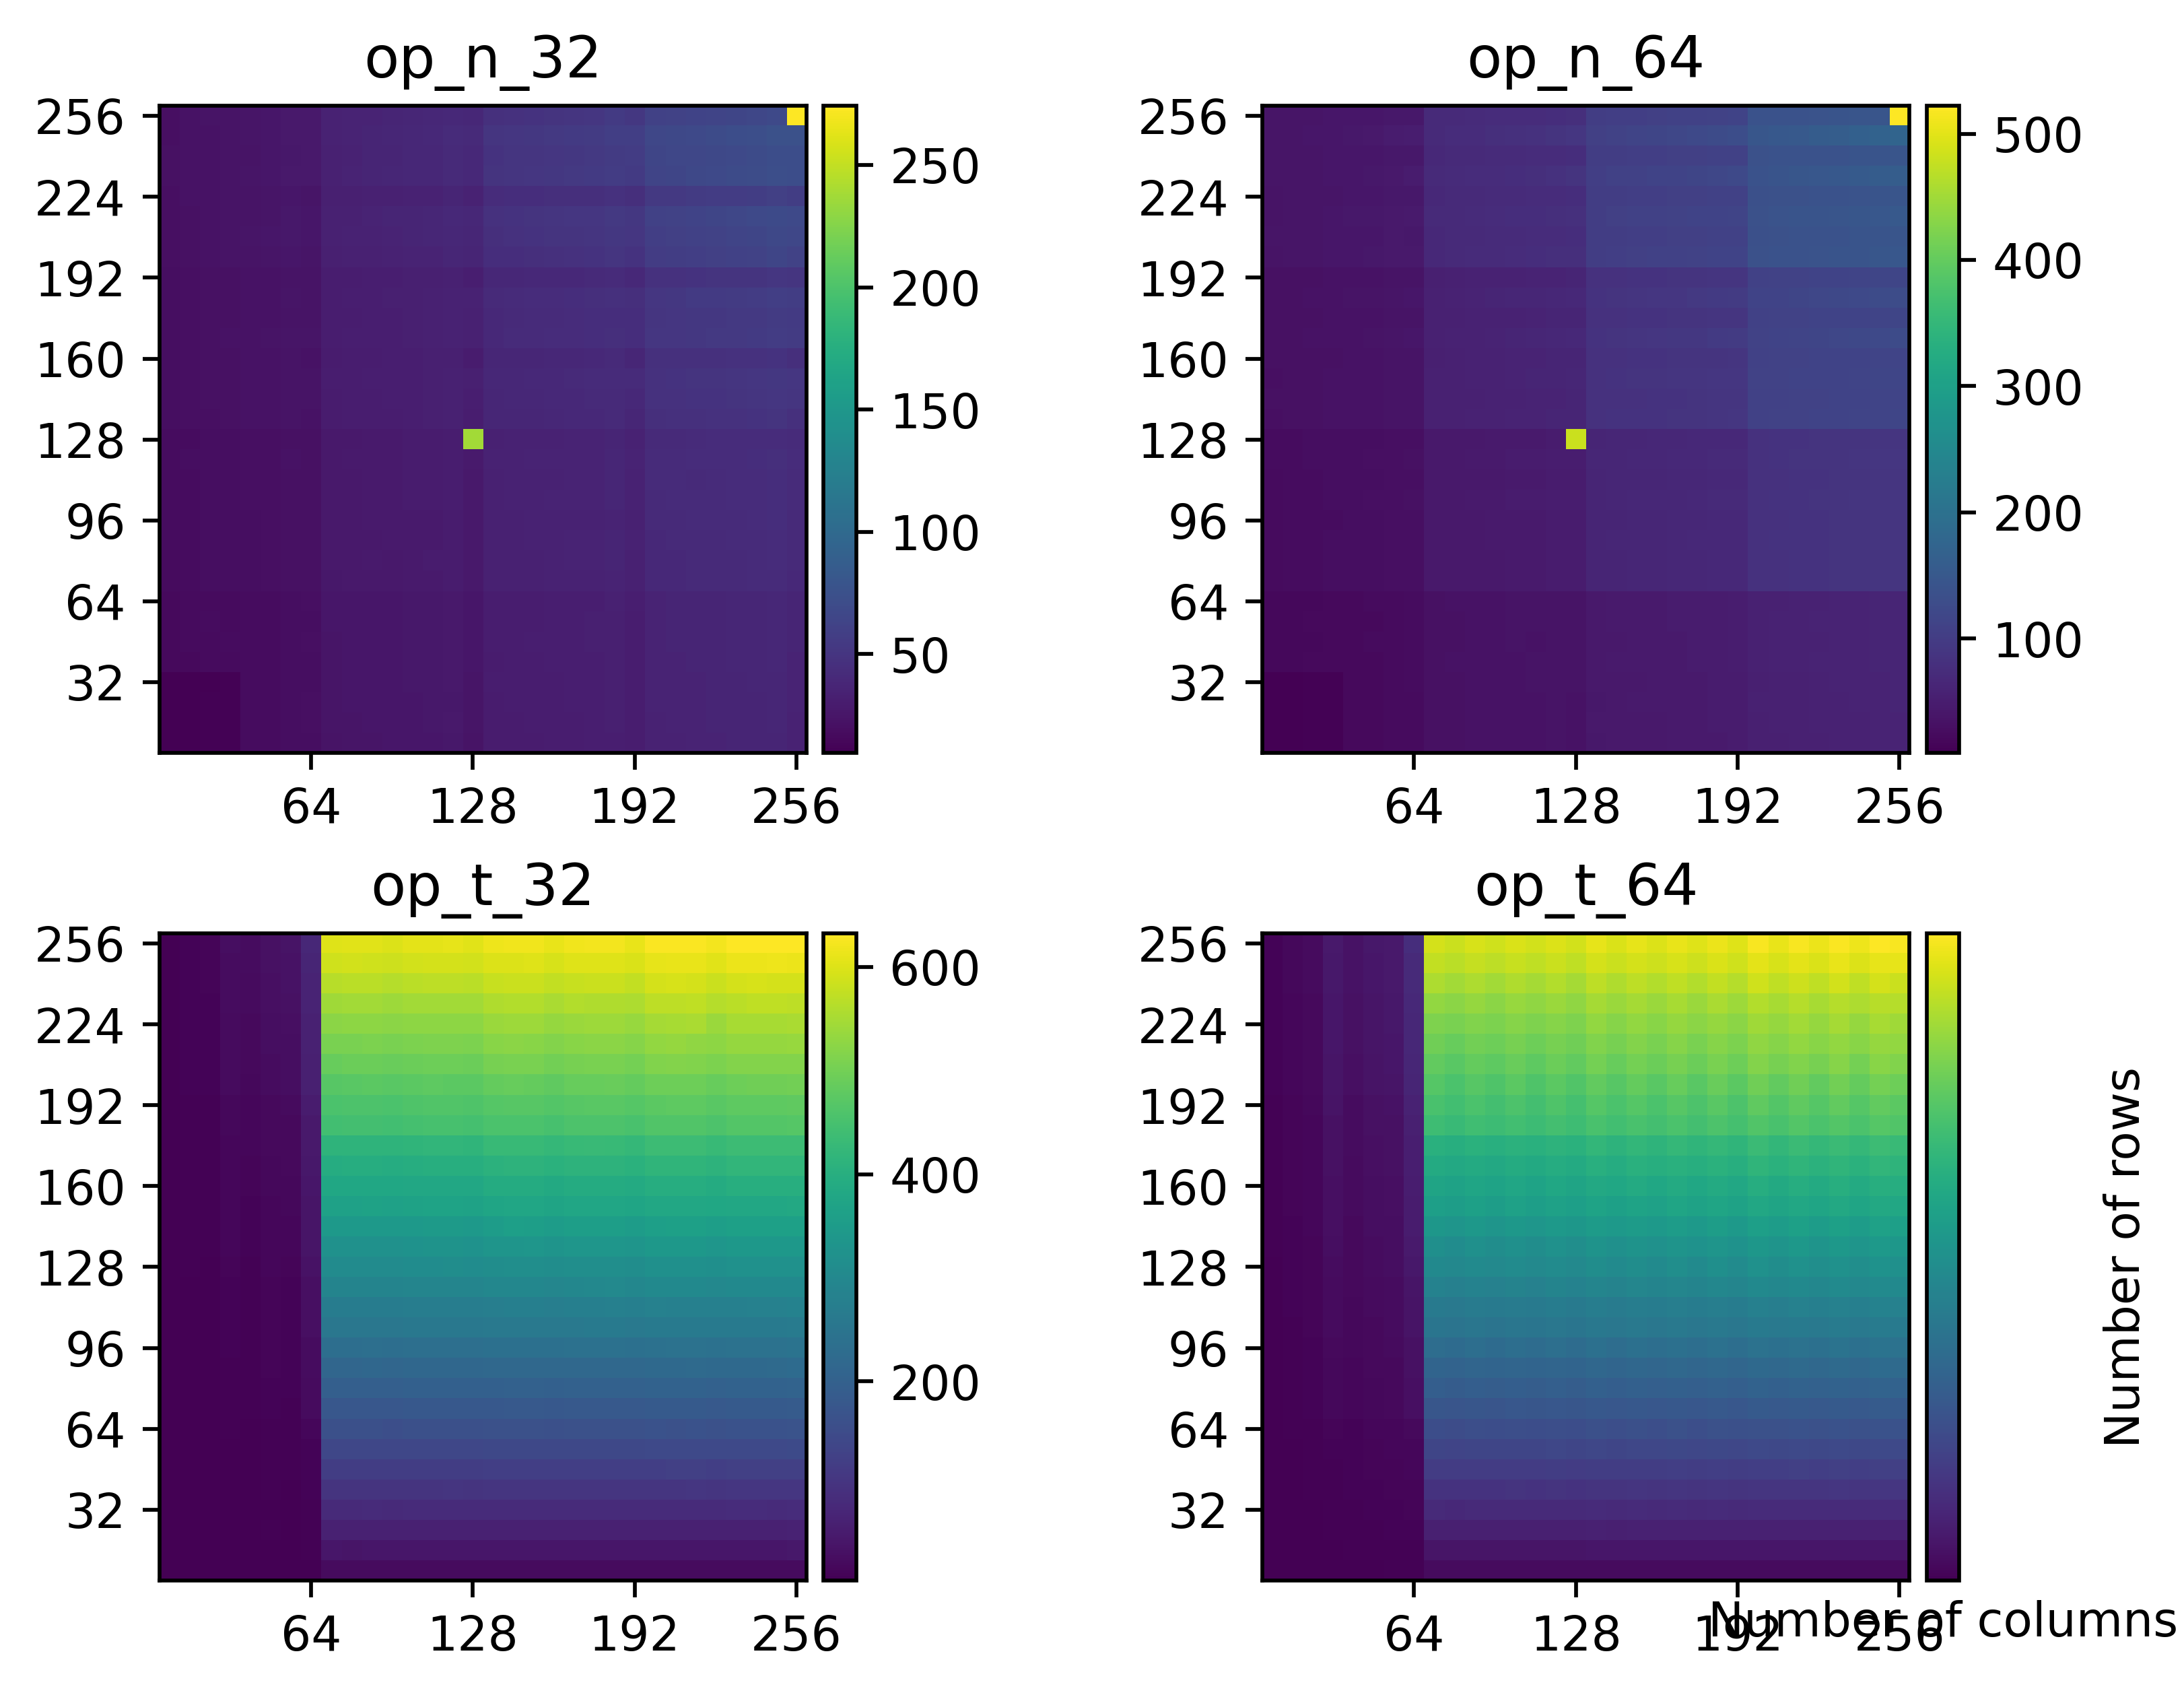

In [57]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig2, axes = plt.subplots(
    2,
    2, 
    subplot_kw=dict(box_aspect=1), 
    layout="constrained",
    dpi=512,
)

fig.add_subplot(111, frameon=False)

titles = ["op_n_32", "op_n_64", "op_t_32", "op_t_64"]
median_arrays = [median_array_op_n_32, median_array_op_n_64, median_array_op_t_32, median_array_op_t_64]

for i, ax in enumerate(axes.flat):
    im = ax.imshow(median_arrays[i],
              origin="lower", 
              interpolation='none',
              extent=[columns_min-columns_interval/2,
                      columns_max+columns_interval/2,
                      rows_min-rows_interval/2,
                      rows_max+rows_interval/2,
                      ],
              )
    ax.title.set_text(titles[i])

    # color bars
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.ax.set_ylabel("milliseconds")

    ticks_stepsize = 4
    ax.set_xticks(range(2*ticks_stepsize*columns_min, columns_max + 1, 2*ticks_stepsize*columns_interval))
    ax.set_yticks(range(ticks_stepsize*rows_min, rows_max + 1, ticks_stepsize*rows_interval))

plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Number of columns")
plt.ylabel("Number of rows")

plt.show()

In [58]:
# # crazy 3d plot
# from matplotlib import cm
# from matplotlib.ticker import LinearLocator

# fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, dpi=256)

# X = np.arange(rows_min, rows_max + 1, rows_interval)
# Y = np.arange(columns_min, columns_max + 1, columns_interval)
# X, Y = np.meshgrid(X, Y)

# Z = op_n_median_array[X%8 - 1, Y%8 - 1]

# surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
# ax.view_init(elev=20.0, azim=-60)
# plt.show()